0.445
0.64
0.19
0.185
0.095
0.445
0.13
0.14
0.08
0.065


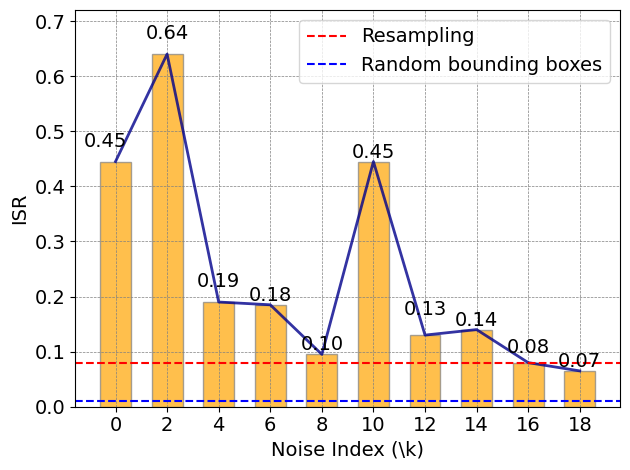

In [7]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt

threshold = 0.75
path = '/home/banyh2000/odfn/wrapup_data/handcraft/hand'
names = os.listdir(path)
list_ = []

for i in range(10):
    with open(os.path.join(path, f'weak_auto_{i*2000}.json')) as f:
        data = json.load(f)
        data = np.array(data)
    length = data.shape[0]
    proportion_above_threshold = np.sum(data > threshold) / length
    print(proportion_above_threshold)
    list_.append(proportion_above_threshold)

# Set up the labels for the x-axis
labels = [f'{i*2}' for i in range(10)]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create orange bar chart
bars = ax.bar(labels, list_, color='orange', alpha=0.7, width=0.6, edgecolor='grey')

shift_x = [-0.2,0,0,0,0,0,0,0,0,0]
shift_y = [0.02,0.02,0.02,0,0,0,0.03,0,0.01,0]
# Add data labels to each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2+ shift_x[i], yval+shift_y[i], f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

# Add grid, labels, and legend with font size adjustments
ax.set_xlabel('Noise Index (\k)', fontsize=14)
ax.set_ylabel('ISR', fontsize=14)
ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')

# Plot a line over the bars
ax.plot(list_, color='darkblue', linewidth=2, alpha=0.8)

# Adjust y-axis to not start from zero, if desired
min_val = min(list_)
max_val = max(list_)

# Set font sizes for the tick labels on both axes
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)

ax.axhline(y=0.08, color='r', linestyle='--', label='Resampling')
ax.axhline(y=0.01, color='b', linestyle='--', label='Random bounding boxes')
# Rotate x-axis labels
# ax.set_xticklabels(labels, rotation=15)  # Rotate labels by 45 degrees for better visibility
ax.set_ylim(0, max_val + 0.08)
# Save and show the figure
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig('/home/banyh2000/odfn/wrapup_data/ISR.png')
plt.show()


In [2]:
import json
import numpy as np
import os
threshold = 0.75
path = '/home/banyh2000/odfn/wrapup_data/handcraft'
names = os.listdir(path)
for name in names:
    with open(os.path.join(path, name)) as f:
        data = json.load(f)
        data = np.array(data)
    length = data.shape[0]
    print(name)
    print(np.sum(data>threshold)/length)


output_functional_10.json
0.49
output_functional_15.json
0.81
output_functional_8.json
0.335
output_re.json
0.085
output_shift_0.8.json
0.085
output_shift_1.2.json
0.29
output_shift_1.5.json
0.9
output_natural.json
0.445
output_random.json
0.01
weak.json
0.25
weak_19990.json
0.17
weak_19999.json
0.12


In [1]:


import random
import numpy as np
from typing import TypeVar
T = TypeVar('T')
from PIL import Image
from pathlib import Path
import os
from tqdm import tqdm
from matplotlib import pyplot as plt


# compute if the p percent of the generated bounding box is in the original bounding box
def Con50(bounding_box_1,bounding_box_2):
    bounding_box_2 = [bounding_box_2[0],bounding_box_2[1],bounding_box_2[2]-bounding_box_2[0],bounding_box_2[3]-bounding_box_2[1]]
    x1 = max(bounding_box_1[0], bounding_box_2[0])
    y1 = max(bounding_box_1[1], bounding_box_2[1])
    x2 = min(bounding_box_1[0] + bounding_box_1[2], bounding_box_2[0] + bounding_box_2[2])
    y2 = min(bounding_box_1[1] + bounding_box_1[3], bounding_box_2[1] + bounding_box_2[3])
    w = max(0, x2 - x1)
    h = max(0, y2 - y1)
    intersection = w * h
    iou = intersection / (bounding_box_1[2] * bounding_box_1[3])
    return iou
    
    
    

bounding_box = [10,30,24,24]
bounding_box_image = [value * 8 for value in bounding_box]

values = []
for i in range(200):

    x,y = random.randint(0,512),random.randint(0,512)
    i,j = random.randint(0,512),random.randint(0,512)
    if x > i:
        x,i = i,x
    if y > j:
        y,j = j,y
    bounding_box_generated = [x,y,i-x,j-y]
    
    iou = Con50(bounding_box_image,bounding_box_generated)
    values.append(iou)
    import json
    with open('/home/banyh2000/odfn/wrapup_data/handcraft/output_random.json','w') as f:
        json.dump(values,f)


In [3]:

import os
os.chdir('/home/banyh2000/odfn')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from scripts.models.diffuserpipeline import StableDiffusionPipeline
import torch
import random
import numpy as np
from typing import TypeVar
T = TypeVar('T')
from PIL import Image
from pathlib import Path
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from mmdet.apis import DetInferencer
from scripts.utils.utils_odfn import variance_5_class_index_sorted, seeds_plus, seeds_plus_dict,variance_index_sorted
inferencer = DetInferencer(model='rtmdet-ins_l_8xb32-300e_coco')

def auto_device(obj: T = torch.device('cpu')) -> T:
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)

    return gen

prompt = "A sports ball is caught in a fence."

model_id = 'stabilityai/stable-diffusion-2-base'
device = 'cuda'
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True).to(device)

import json
if os.path.exists('/home/banyh2000/odfn/wrapup_data/handcraft/bounding boxes_1.json'):
    with open('/home/banyh2000/odfn/wrapup_data/handcraft/bounding boxes_1.json','r') as f:
        dict_ = json.load(f)
else:
    dict_ = {}
    
for i in range(0,20000,1000):
    seed = seeds_plus[variance_index_sorted[i+1]]
    with torch.no_grad():
        out = pipe(prompt=prompt, generator=set_seed(seed))
        out.images[0].save(f'/home/banyh2000/odfn/wrapup_data/handcraft/{i+1}_1.png')
        image = np.array(out.images[0])
        results = inferencer(image)
        bounding_box_generated = results['predictions'][0]['bboxes'][0]
        bounding_box = [value/8 for value in bounding_box_generated]
        dict_[i+1] = bounding_box
            
    import json
    with open('/home/banyh2000/odfn/wrapup_data/hand/bounding boxes_1.json','w') as f:
        json.dump(dict_,f)

/home/banyh2000/anaconda3/envs/odfn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/banyh2000/anaconda3/envs/odfn/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet-ins_l_8xb32-300e_coco/rtmdet-ins_l_8xb32-300e_coco_20221124_103237-78d1d652.pth
05/20 18:27:55 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/home/banyh2000/anaconda3/envs/odfn/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.
100%|██████████| 50/50 [00:06<00:00,  7.23it/s]


/home/banyh2000/anaconda3/envs/odfn/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/banyh2000/anaconda3/envs/odfn/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: 
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at
/opt/conda/conda-bld/pytorch_1646755888698/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

100%|██████████| 50/50 [00:04<00:00, 11.49it/s]


100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


100%|██████████| 50/50 [00:04<00:00, 11.46it/s]


100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


100%|██████████| 50/50 [00:04<00:00, 11.44it/s]


100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


100%|██████████| 50/50 [00:04<00:00, 11.39it/s]


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


100%|██████████| 50/50 [00:04<00:00, 11.38it/s]


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]
